In [1]:
import os
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2

In [2]:
class ROOTDIR:
    root = "/data1/vinod/mitosis/data/processed"

In [3]:
train_img_lst = os.listdir(os.path.join(ROOTDIR.root, 'train', 'input')) # "./train"
train_mask_lst = os.listdir(os.path.join(ROOTDIR.root, 'train', 'output')) # "./train_masks"
val_img_lst = os.listdir(os.path.join(ROOTDIR.root, 'val', 'input')) # "./val"
val_mask_lst = os.listdir(os.path.join(ROOTDIR.root, 'val', 'output')) # "./val_masks"

In [4]:
print(train_mask_lst[:5])
print(train_img_lst[:5])
print(val_mask_lst[:5])
print(val_img_lst[:5])

['A02_05.png', 'H00_01.png', 'H02_05.png', 'A00_01.png', 'A00_03.png']
['A02_05.png', 'H00_01.png', 'H02_05.png', 'A00_01.png', 'A00_03.png']
['A00_02.png', 'A01_01.png', 'A01_08.png', 'A02_03.png', 'A02_08.png']
['A00_02.png', 'A01_01.png', 'A01_08.png', 'A02_03.png', 'A02_08.png']


In [5]:
print(len(train_mask_lst))
print(len(train_img_lst))
print(len(val_mask_lst))
print(len(val_img_lst))

79
79
19
19


In [6]:
sorted_train_mask_lst = sorted(train_mask_lst)
sorted_train_img_lst = sorted(train_img_lst)
sorted_val_mask_lst = sorted(val_mask_lst)
sorted_val_img_lst = sorted(val_img_lst)

/data1/vinod/mitosis/data/processed/train/input/A00_01.png
(2084, 2084)


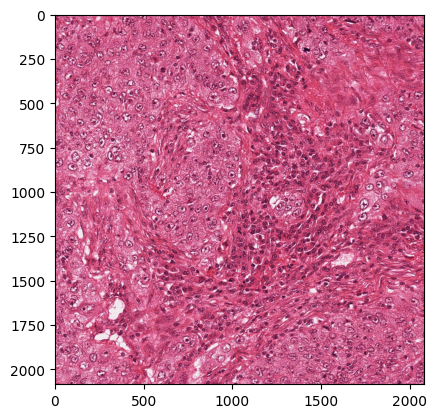

/data1/vinod/mitosis/data/processed/train/output/A00_01.png
(2084, 2084)


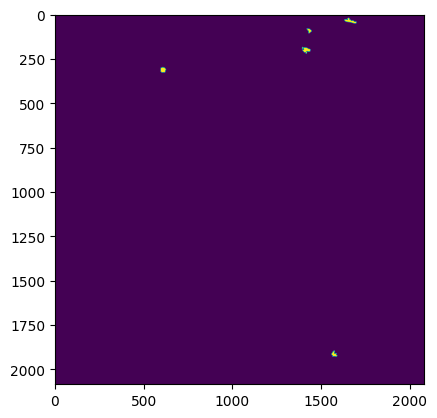

----------------------------------------------------
/data1/vinod/mitosis/data/processed/train/input/A00_03.png
(2084, 2084)


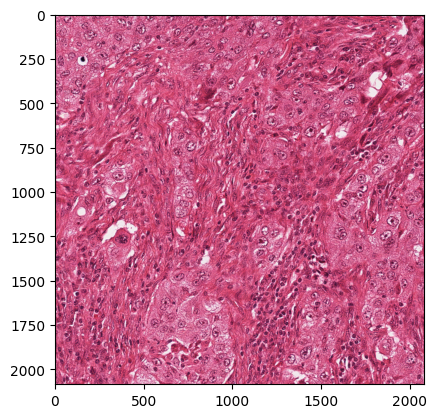

/data1/vinod/mitosis/data/processed/train/output/A00_03.png
(2084, 2084)


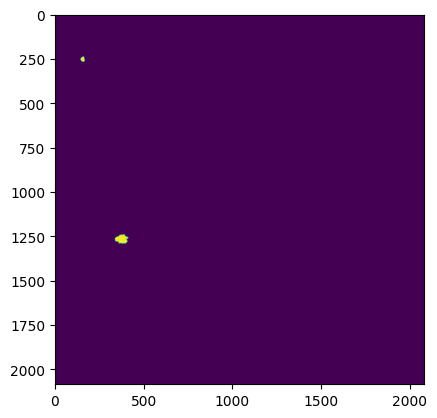

----------------------------------------------------


In [7]:
def show_images(imgs_lst,masks_lst,type='train',loops=2):
    for i in range(loops):
        img_path = os.path.join(ROOTDIR.root,type,'input',imgs_lst[i])
        mask_path = os.path.join(ROOTDIR.root,type,'output', masks_lst[i])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        print(img_path)
        print(img.size)
        # print(type(img))
        plt.imshow(img)
        plt.show()
        print(mask_path)
        print(mask.size)
        plt.imshow(mask)
        plt.show()
        print("----------------------------------------------------")

show_images(sorted_train_img_lst, sorted_train_mask_lst, type='train')

### Pytorch Implementation

In [8]:
import torch
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset

#### Configurations

In [9]:
class CFG:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    split_pct = 0.2
    learning_rate = 3e-4
    batch_size = 8
    epochs = 50

In [10]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

In [11]:
CFG.device

device(type='cuda')

#### Workign with data

##### Shuffling the data

In [12]:
permuted_train_img_lst = np.random.permutation(np.array(sorted_train_img_lst))
permuted_train_mask_lst = [x for x in permuted_train_img_lst]
print(permuted_train_img_lst[:5])
print(permuted_train_mask_lst[:5])

['H03_01.png' 'H02_04.png' 'H02_05.png' 'A00_06.png' 'H03_08.png']
['H03_01.png', 'H02_04.png', 'H02_05.png', 'A00_06.png', 'H03_08.png']


/data1/vinod/mitosis/data/processed/train/input/H03_01.png
(2252, 2250)


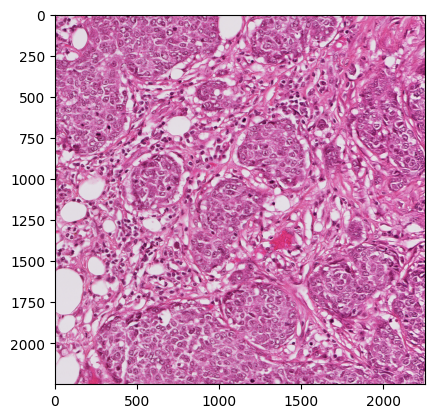

/data1/vinod/mitosis/data/processed/train/output/H03_01.png
(2252, 2250)


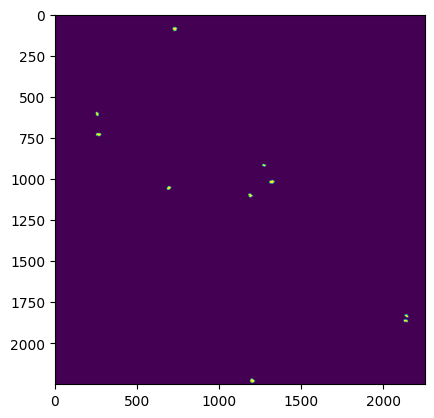

----------------------------------------------------
/data1/vinod/mitosis/data/processed/train/input/H02_04.png
(2252, 2250)


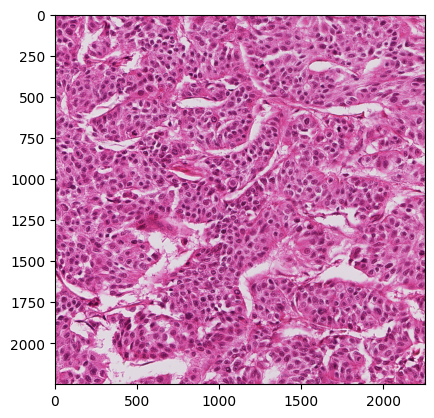

/data1/vinod/mitosis/data/processed/train/output/H02_04.png
(2252, 2250)


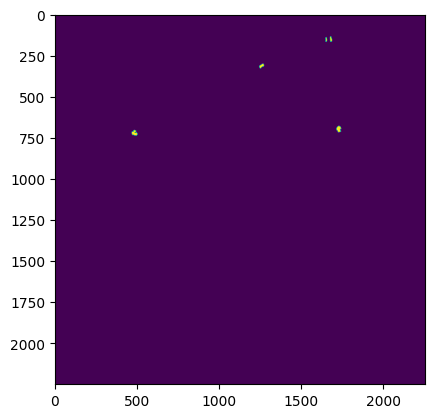

----------------------------------------------------


In [13]:
show_images(permuted_train_img_lst,permuted_train_mask_lst, type='train')

In [14]:
train_images_list = permuted_train_img_lst
train_masks_list = permuted_train_mask_lst
print(len(train_masks_list))

val_images_list = val_img_lst
val_masks_list = val_mask_lst
print(len(val_masks_list))

79
19


#### Visualizing Train Dataset

/data1/vinod/mitosis/data/processed/train/input/H03_01.png
(2252, 2250)


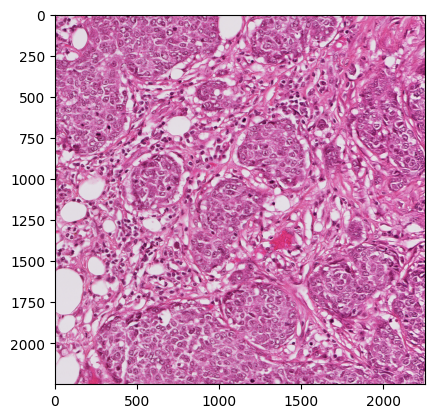

/data1/vinod/mitosis/data/processed/train/output/H03_01.png
(2252, 2250)


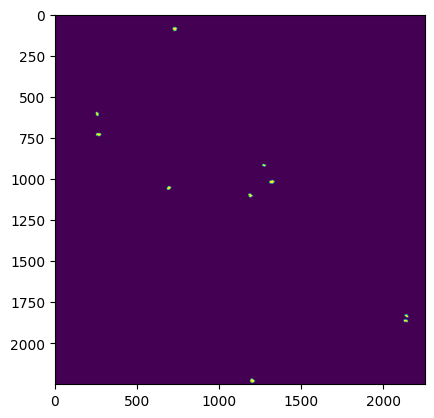

----------------------------------------------------
/data1/vinod/mitosis/data/processed/train/input/H02_04.png
(2252, 2250)


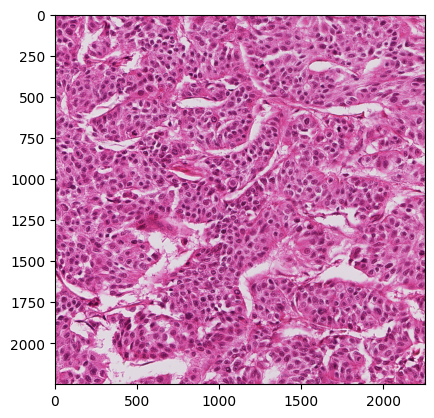

/data1/vinod/mitosis/data/processed/train/output/H02_04.png
(2252, 2250)


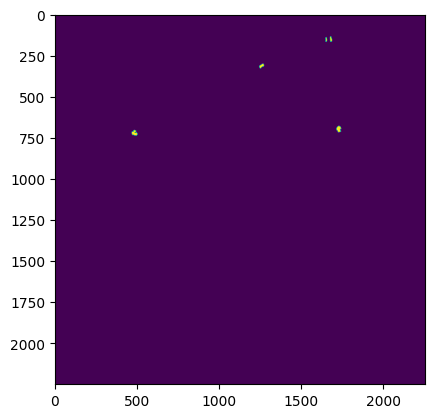

----------------------------------------------------


In [15]:
show_images(train_images_list,train_masks_list,type='train')

##### Visualizing Val Dataset

/data1/vinod/mitosis/data/processed/val/input/A00_02.png
(2084, 2084)


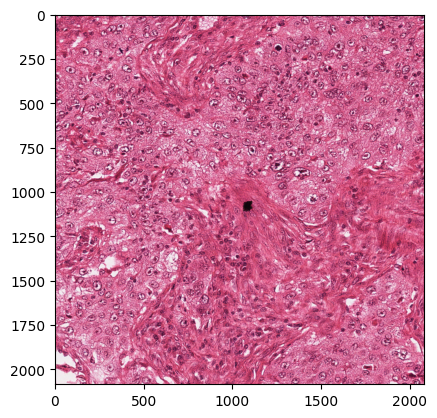

/data1/vinod/mitosis/data/processed/val/output/A00_02.png
(2084, 2084)


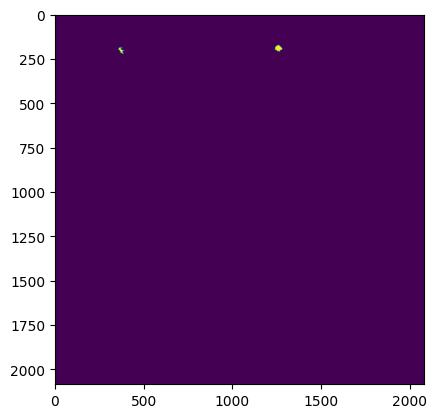

----------------------------------------------------
/data1/vinod/mitosis/data/processed/val/input/A01_01.png
(2084, 2084)


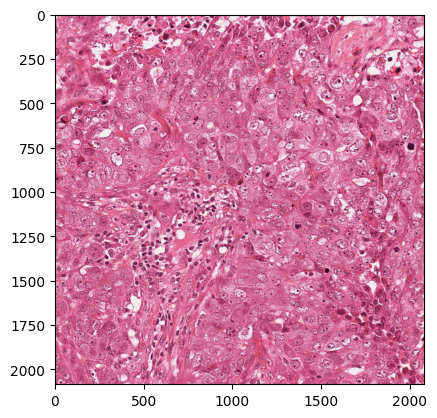

/data1/vinod/mitosis/data/processed/val/output/A01_01.png
(2084, 2084)


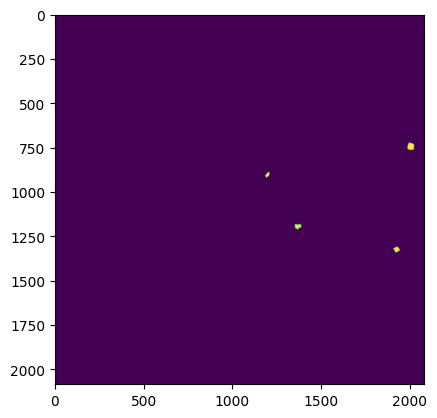

----------------------------------------------------


In [16]:
show_images(val_images_list,val_masks_list,type='val')

#### Dataset Class

In [17]:
class MitosisDataset(Dataset):
    def __init__(self,img_list,mask_list,type=None,transform=None):
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform
        self.type = type
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,index):
        img_path = os.path.join(ROOTDIR.root, self.type, 'input', self.img_list[index])
        mask_path = os.path.join(ROOTDIR.root, self.type, 'output', self.mask_list[index])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        img = np.array(img)
        mask = np.array(mask)
        mask[mask==255.0] = 1.0

        if self.transform:
            augmentation = self.transform(image=img, mask=mask)
            img = augmentation["image"]
            mask = augmentation["mask"]
            mask = torch.unsqueeze(mask,0)

            
        return img,mask

In [18]:
train_transform = A.Compose([A.Resize(572,572), 
                             A.Rotate(limit=15,p=0.1),
                             A.HorizontalFlip(p=0.5),
                             A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                             ToTensorV2()])

val_transform = A.Compose([A.Resize(572,572),
                           A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                           ToTensorV2()])

In [19]:
train_dataset = MitosisDataset(train_images_list, train_masks_list, type='train', transform = train_transform)
val_dataset = MitosisDataset(val_images_list, val_masks_list, type='val', transform = val_transform)

In [20]:
idx = 10
img,mask = train_dataset[idx]

In [21]:
mask.shape

torch.Size([1, 572, 572])

In [22]:
img.max()

tensor(1.)

In [23]:
def show_single_img(img,mask,index=None,train=True):
    if index:
        if train:
            img,mask = train_dataset[index]
        else:
            img,mask = val_dataset[index]
    plt.imshow(img.permute(1,2,0),cmap="gray")  # Convert (3, 572, 572) -> (572, 572, 3)
    plt.show()
    plt.imshow(mask.permute(1,2,0), cmap="gray")  # Convert (1, 572, 572) -> (572, 572, 1)
    print(mask.shape)
    plt.show()

---------------Train---------------


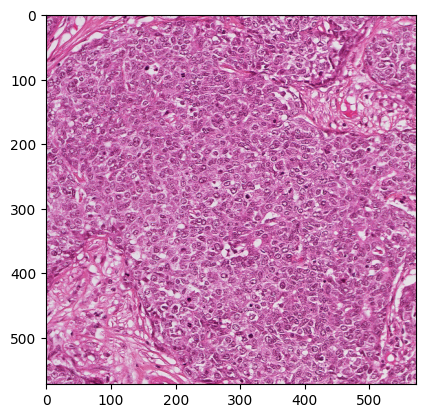

torch.Size([1, 572, 572])


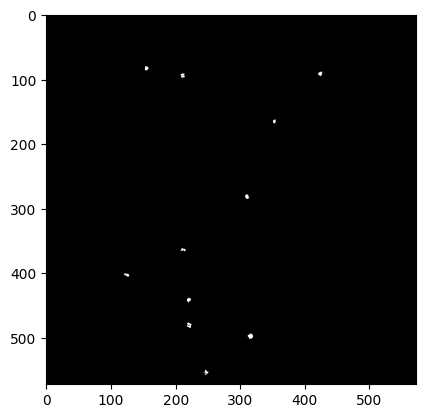

---------------Validation---------------


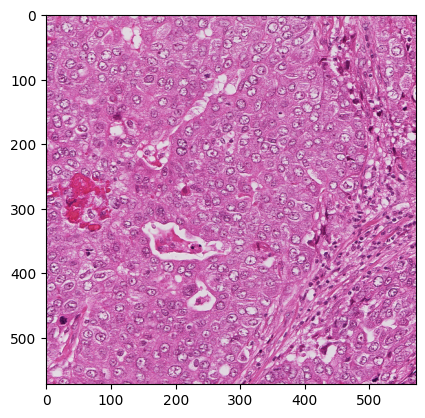

torch.Size([1, 572, 572])


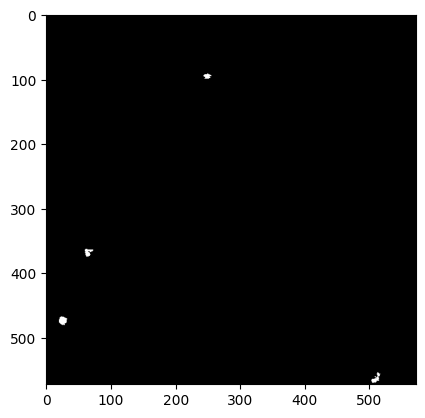

In [24]:
print("---------------Train---------------")
show_single_img(img,mask,index=15,train=False)
print("---------------Validation---------------")
show_single_img(img,mask,index=15,train=True)

#### Data Loader

In [25]:
train_dataloader = DataLoader(train_dataset,batch_size=CFG.batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=CFG.batch_size,shuffle=False)

In [26]:
a = train_dataloader
img,mask = next(iter(a))
print(img.shape,mask.shape)

torch.Size([8, 3, 572, 572]) torch.Size([8, 1, 572, 572])


#### Utility functions

In [27]:
def double_conv(in_ch, out_ch):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1), 
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True)
    )
    
    return conv

#def cropper(og_tensor, target_tensor):
#    og_shape = og_tensor.shape[2]
#    target_shape = target_tensor.shape[2]
#    delta = (og_shape - target_shape) // 2
#    cropped_og_tensor = og_tensor[:,:,delta:og_shape-delta,delta:og_shape-delta]
#    return cropped_og_tensor
 
    
def padder(left_tensor, right_tensor): 
    # left_tensor is the tensor on the encoder side of UNET
    # right_tensor is the tensor on the decoder side  of the UNET
    
    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(CFG.device)
    
    return right_tensor.to(CFG.device)

#### UNet Model

In [28]:
class UNET(nn.Module):
    def __init__(self,in_chnls, n_classes):
        super(UNET,self).__init__()
        
        self.in_chnls = in_chnls
        self.n_classes = n_classes
        
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.down_conv_1 = double_conv(in_ch=self.in_chnls,out_ch=64)
        self.down_conv_2 = double_conv(in_ch=64,out_ch=128)
        self.down_conv_3 = double_conv(in_ch=128,out_ch=256)
        self.down_conv_4 = double_conv(in_ch=256,out_ch=512)
        self.down_conv_5 = double_conv(in_ch=512,out_ch=1024)
        #print(self.down_conv_1)
        
        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        
        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64)
        
        self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.n_classes,kernel_size=1,stride=1)
        
    def forward(self,x):
        
        # encoding
        x1 = self.down_conv_1(x)
        #print("X1", x1.shape)
        p1 = self.max_pool(x1)
        #print("p1", p1.shape)
        x2 = self.down_conv_2(p1)
        #print("X2", x2.shape)
        p2 = self.max_pool(x2)
        #print("p2", p2.shape)
        x3 = self.down_conv_3(p2)
        #print("X2", x3.shape)
        p3 = self.max_pool(x3)
        #print("p3", p3.shape)
        x4 = self.down_conv_4(p3)
        #print("X4", x4.shape)
        p4 = self.max_pool(x4)
        #print("p4", p4.shape)
        x5 = self.down_conv_5(p4)
        #print("X5", x5.shape)
        
        # decoding
        d1 = self.up_conv_trans_1(x5)  # up transpose convolution ("up sampling" as called in UNET paper)
        pad1 = padder(x4,d1) # padding d1 to match x4 shape
        cat1 = torch.cat([x4,pad1],dim=1) # concatenating padded d1 and x4 on channel dimension(dim 1) [batch(dim 0),channel(dim 1),height(dim 2),width(dim 3)]
        uc1 = self.up_conv_1(cat1) # 1st up double convolution
        
        d2 = self.up_conv_trans_2(uc1)
        pad2 = padder(x3,d2)
        cat2 = torch.cat([x3,pad2],dim=1)
        uc2 = self.up_conv_2(cat2)
        
        d3 = self.up_conv_trans_3(uc2)
        pad3 = padder(x2,d3)
        cat3 = torch.cat([x2,pad3],dim=1)
        uc3 = self.up_conv_3(cat3)
        
        d4 = self.up_conv_trans_4(uc3)
        pad4 = padder(x1,d4)
        cat4 = torch.cat([x1,pad4],dim=1)
        uc4 = self.up_conv_4(cat4)
        
        conv_1x1 = self.conv_1x1(uc4)
        return conv_1x1
        #print(conv_1x1.shape)

In [29]:
def dice_loss(preds, targets):
    smooth = 1e-7
    intersection = torch.sum(preds * targets)
    union = torch.sum(preds) + torch.sum(targets)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

In [30]:
model = UNET(in_chnls = 3, n_classes = 1).to(CFG.device)
optimizer = optim.Adam(model.parameters(), lr = CFG.learning_rate)
criterion = nn.BCEWithLogitsLoss()
criterion_dice = dice_loss
train_loss_lst = []
val_loss_lst = []
val_diceloss_lst = [] 

#### Train and Validation

##### Train

In [31]:
def train_model(model,dataloader,criterion,optimizer):
    model.train()
    train_running_loss = 0.0
    for j,img_mask in enumerate(tqdm(dataloader)):
        img = img_mask[0].float().to(CFG.device)
        #print(" ----- IMAGE -----")
        #print(img)
        mask = img_mask[1].float().to(CFG.device)
        #print(" ----- MASK -----")
        #print(mask)
        
        y_pred = model(img)
        #print(" ----- Y PRED -----")
        #print(y_pred)
        #print(" ----- Y PRED SHAPE -----")#
        #print(y_pred.shape)
        optimizer.zero_grad()
        
        loss = criterion(y_pred,mask)
        
        train_running_loss += loss.item() * CFG.batch_size
        
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / (j+1)
    return train_loss

##### Validation

In [32]:
def val_model(model,dataloader,criterion,criterion_dice,optimizer):
    model.eval()
    val_running_loss = 0
    val_running_diceloss = 0
    with torch.no_grad():
        for j,img_mask in enumerate(tqdm(dataloader)):
            img = img_mask[0].float().to(CFG.device)
            mask = img_mask[1].float().to(CFG.device)
            y_pred = model(img)
            
            loss = criterion(y_pred,mask)
            val_running_loss += loss.item() * CFG.batch_size

            diceloss = criterion_dice(y_pred,mask)
            val_running_diceloss += diceloss.item() * CFG.batch_size
            
        val_loss = val_running_loss / (j+1)
        val_diceloss = val_running_diceloss / (j+1)
    return val_loss, val_diceloss

#### Train and Validation Loop

In [34]:
for i in tqdm(range(CFG.epochs)):
    train_loss = train_model(model=model,dataloader=train_dataloader,criterion=criterion,optimizer=optimizer)
    val_loss, val_diceloss = val_model(model=model,dataloader=val_dataloader,criterion=criterion,criterion_dice=criterion_dice,optimizer=optimizer)
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)
    val_diceloss_lst.append(val_diceloss)
    print(f" Train Loss : {train_loss:.4f}")
    print(f" Validation Loss : {val_loss:.4f}")
    print(f" Validation Dice Loss : {val_diceloss:.4f}")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 3.0332
 Validation Loss : 3.4695
 Validation Dice Loss : 7.9839


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 2.4224
 Validation Loss : 2.8234
 Validation Dice Loss : 7.9842


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 2.1273
 Validation Loss : 2.3667
 Validation Dice Loss : 7.9844


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 1.9540
 Validation Loss : 2.1606
 Validation Dice Loss : 7.9838


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 1.8375
 Validation Loss : 1.9753
 Validation Dice Loss : 7.9834


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 1.7437
 Validation Loss : 1.9327
 Validation Dice Loss : 7.9974


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 1.6844
 Validation Loss : 2.5414
 Validation Dice Loss : 8.1197


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 1.6558
 Validation Loss : 1.5833
 Validation Dice Loss : 7.9735


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 1.5255
 Validation Loss : 1.6606
 Validation Dice Loss : 7.9913


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 1.4053
 Validation Loss : 1.4509
 Validation Dice Loss : 7.9843


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 1.3224
 Validation Loss : 1.3524
 Validation Dice Loss : 7.9847


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 1.2477
 Validation Loss : 1.2865
 Validation Dice Loss : 7.9849


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 1.1757
 Validation Loss : 1.1914
 Validation Dice Loss : 7.9848


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 1.1147
 Validation Loss : 1.1297
 Validation Dice Loss : 7.9846


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 1.0635
 Validation Loss : 1.0619
 Validation Dice Loss : 7.9837


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 1.0193
 Validation Loss : 1.0097
 Validation Dice Loss : 7.9850


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.9706
 Validation Loss : 0.9615
 Validation Dice Loss : 7.9853


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.9222
 Validation Loss : 0.9066
 Validation Dice Loss : 7.9858


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.8820
 Validation Loss : 0.8676
 Validation Dice Loss : 7.9852


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.8423
 Validation Loss : 0.8320
 Validation Dice Loss : 7.9858


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.8008
 Validation Loss : 0.7666
 Validation Dice Loss : 7.9861


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.7667
 Validation Loss : 0.7431
 Validation Dice Loss : 7.9862


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.7339
 Validation Loss : 0.7214
 Validation Dice Loss : 7.9863


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.7012
 Validation Loss : 0.6942
 Validation Dice Loss : 7.9866


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.6692
 Validation Loss : 0.6406
 Validation Dice Loss : 7.9868


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.6403
 Validation Loss : 0.6183
 Validation Dice Loss : 7.9864


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.6145
 Validation Loss : 0.6170
 Validation Dice Loss : 7.9894


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.5908
 Validation Loss : 0.5670
 Validation Dice Loss : 7.9865


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.5610
 Validation Loss : 0.5444
 Validation Dice Loss : 7.9876


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.5378
 Validation Loss : 0.5075
 Validation Dice Loss : 7.9889


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.5163
 Validation Loss : 0.5099
 Validation Dice Loss : 7.9873


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.4937
 Validation Loss : 0.4778
 Validation Dice Loss : 7.9893


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.4779
 Validation Loss : 0.4504
 Validation Dice Loss : 7.9887


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.4570
 Validation Loss : 0.4355
 Validation Dice Loss : 7.9906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.4396
 Validation Loss : 0.4211
 Validation Dice Loss : 7.9892


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.4225
 Validation Loss : 0.4010
 Validation Dice Loss : 7.9909


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.4057
 Validation Loss : 0.3932
 Validation Dice Loss : 7.9905


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.3920
 Validation Loss : 0.3863
 Validation Dice Loss : 7.9898


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.3806
 Validation Loss : 0.3658
 Validation Dice Loss : 7.9873


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.3646
 Validation Loss : 0.3523
 Validation Dice Loss : 7.9916


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.3504
 Validation Loss : 0.3429
 Validation Dice Loss : 7.9919


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.3376
 Validation Loss : 0.3336
 Validation Dice Loss : 7.9908


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.3260
 Validation Loss : 0.3220
 Validation Dice Loss : 7.9905


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.3153
 Validation Loss : 0.3085
 Validation Dice Loss : 7.9891


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.3058
 Validation Loss : 0.2970
 Validation Dice Loss : 7.9920


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.2952
 Validation Loss : 0.2926
 Validation Dice Loss : 7.9888


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.2877
 Validation Loss : 0.2740
 Validation Dice Loss : 7.9926


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.2772
 Validation Loss : 0.2666
 Validation Dice Loss : 7.9925


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.2677
 Validation Loss : 0.2593
 Validation Dice Loss : 7.9926


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Train Loss : 0.2593
 Validation Loss : 0.2551
 Validation Dice Loss : 7.9931


#### Training and Validation Loss Plot

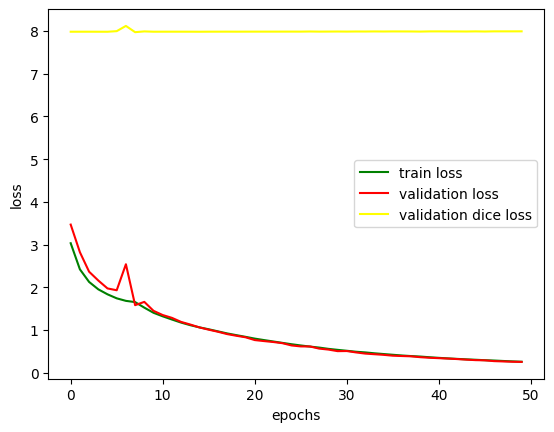

In [35]:
plt.plot(train_loss_lst, color="green", label='train loss')
plt.plot(val_loss_lst, color="red", label='validation loss')
plt.plot(val_diceloss_lst, color="yellow", label='validation dice loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

#### Saving Model

In [36]:
TRAINED_FILE = "/home/vinod/Documents/mitosis_detection/models/UNet/version1.1/unet.pth"

In [37]:
torch.save(model.state_dict(), TRAINED_FILE)

In [38]:
from IPython.display import FileLink
FileLink(TRAINED_FILE)

/home/vinod/Documents/mitosis_detection/models/UNet/version1.1/unet.pth

#### Testing

In [39]:
trained_model = UNET(in_chnls = 3, n_classes = 1)
UNET_TRAINED = "/home/vinod/Documents/mitosis_detection/models/UNet/version1.1/unet.pth"
trained_model.load_state_dict(torch.load(UNET_TRAINED))

<All keys matched successfully>

In [40]:
trained_model = trained_model.to("cuda")
trained_model.eval()

UNET(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=

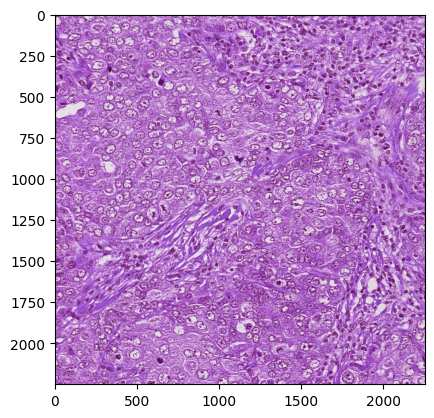

In [41]:
img_path = "/data1/vinod/mitosis/data/processed/val/input/H04_04.png"
img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

In [42]:
test_transform = A.Compose([A.Resize(572,572),
                           A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                           ToTensorV2()])

test_image = test_transform(image = img)

print(test_image)

print(test_image["image"].dtype)
print(test_image["image"].shape)

img = test_image["image"].unsqueeze(0)
print(img.shape)

img = img.to("cuda")

{'image': tensor([[[0.7451, 0.7529, 0.6314,  ..., 0.5490, 0.4275, 0.3608],
         [0.8039, 0.7608, 0.7686,  ..., 0.5804, 0.4314, 0.4275],
         [0.7333, 0.7647, 0.7098,  ..., 0.8118, 0.7294, 0.6588],
         ...,
         [0.7412, 0.6275, 0.6549,  ..., 0.8706, 0.8824, 0.8902],
         [0.6471, 0.7608, 0.5804,  ..., 0.8431, 0.8824, 0.8941],
         [0.7373, 0.8196, 0.7765,  ..., 0.8392, 0.8627, 0.8745]],

        [[0.5098, 0.4941, 0.4039,  ..., 0.2706, 0.1804, 0.1059],
         [0.6706, 0.5843, 0.5922,  ..., 0.3176, 0.1451, 0.1569],
         [0.3412, 0.4157, 0.3647,  ..., 0.6627, 0.5922, 0.5412],
         ...,
         [0.4392, 0.3294, 0.3059,  ..., 0.8000, 0.8471, 0.8314],
         [0.3961, 0.5176, 0.3922,  ..., 0.7569, 0.8471, 0.8392],
         [0.4510, 0.5216, 0.5686,  ..., 0.7725, 0.8235, 0.8353]],

        [[0.8157, 0.8157, 0.7647,  ..., 0.5961, 0.4941, 0.3294],
         [0.9569, 0.9059, 0.9216,  ..., 0.6353, 0.3765, 0.3843],
         [0.5451, 0.6706, 0.6863,  ..., 0.9529, 

In [43]:
pred = trained_model(img)
pred.shape

torch.Size([1, 1, 572, 572])

In [44]:
mask = pred.squeeze(0).cpu().detach().numpy()
print(mask.shape)
mask = mask.transpose(1,2,0)
print(mask.shape)

(1, 572, 572)
(572, 572, 1)


In [45]:
display_test_img = test_image["image"].cpu().detach().numpy()
print(display_test_img.shape)
display_test_img = display_test_img.transpose(1,2,0)
display_test_img.shape

(3, 572, 572)


(572, 572, 3)

In [46]:
mask[mask < 0]=0
mask[mask > 0]=1

-------Original Image-------


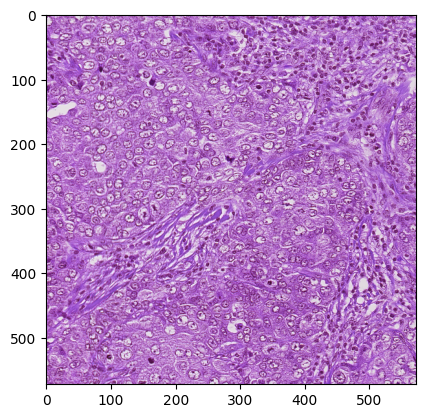

-------Image Mask-------


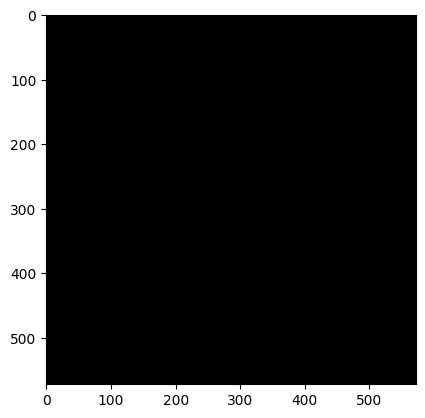

In [47]:
print("-------Original Image-------")
plt.imshow(display_test_img, cmap="gray")
plt.show()
print("-------Image Mask-------")
plt.imshow(mask,cmap="gray")
plt.show()